In [125]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [126]:
data = pd.read_csv("QuangNinh.csv", parse_dates=["date"], index_col=["date"])
start_date = '2019-03-01'
end_date = '2024-03-01'
df = data.loc[start_date:end_date]
df

,Unnamed: 0,pm25,pm10,o3,no2,so2,co,AQI
date,,,,,,,,
2021-02-14,1,20,6,28,5,12,5,20
2021-02-15,2,9,14,28,9,12,5,14
2021-02-16,3,18,17,26,9,12,6,18
2021-02-17,4,20,24,26,15,12,6,24
2021-02-18,5,28,29,38,16,12,6,29
...,...,...,...,...,...,...,...,...
2024-02-26,901,7,4,8,3,6,5,7
2024-02-27,902,4,12,4,11,9,6,12
2024-02-28,903,11,6,9,5,7,6,11


In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 905 entries, 2021-02-14 to 2024-03-01
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Unnamed: 0  905 non-null    int64
 1   pm25        905 non-null    int64
 2   pm10        905 non-null    int64
 3   o3          905 non-null    int64
 4   no2         905 non-null    int64
 5   so2         905 non-null    int64
 6   co          905 non-null    int64
 7   AQI         905 non-null    int64
dtypes: int64(8)
memory usage: 63.6 KB


In [128]:
df_aqi = pd.DataFrame(df["AQI"])

In [129]:
timesteps = df_aqi.index.to_numpy()
aqi_arr = df_aqi["AQI"].to_numpy()

In [130]:
timesteps

array(['2021-02-14T00:00:00.000000000', '2021-02-15T00:00:00.000000000',
       '2021-02-16T00:00:00.000000000', '2021-02-17T00:00:00.000000000',
       '2021-02-18T00:00:00.000000000', '2021-02-19T00:00:00.000000000',
       '2021-02-20T00:00:00.000000000', '2021-02-21T00:00:00.000000000',
       '2021-02-22T00:00:00.000000000', '2021-02-23T00:00:00.000000000',
       '2021-02-24T00:00:00.000000000', '2021-02-25T00:00:00.000000000',
       '2021-02-26T00:00:00.000000000', '2021-02-27T00:00:00.000000000',
       '2021-02-28T00:00:00.000000000', '2021-03-01T00:00:00.000000000',
       '2021-03-02T00:00:00.000000000', '2021-03-03T00:00:00.000000000',
       '2021-03-04T00:00:00.000000000', '2021-03-05T00:00:00.000000000',
       '2021-03-06T00:00:00.000000000', '2021-03-07T00:00:00.000000000',
       '2021-03-08T00:00:00.000000000', '2021-03-09T00:00:00.000000000',
       '2021-03-10T00:00:00.000000000', '2021-03-11T00:00:00.000000000',
       '2021-03-12T00:00:00.000000000', '2021-03-13

In [131]:
aqi_arr

array([ 20,  14,  18,  24,  29,  37,  47,  36,  34,  27,  27,  39,  43,
        49,  52,  52,  19,  17,  14,  41,  38,  41,  57,  56,  46,  54,
        57,  56,  46,  42,  48,  53,  62,  70,  42,  24,  22,  20,  46,
        54,  61,  47,  44,  45,  48,  75,  84,  45,  47,  60,  91,  51,
        47,  38,  39,  39,  35,  34,  35,  44,  37,  45,  48,  40,  47,
        41,  24,  37,  89,  89,  89,  89,  54,  31,  30,  34,  44,  26,
        21,  25,  86,  88,  88,  88,  88,  88,  88,  51,  31,  62,  88,
        88,  88,  88,  88,  88,  88,  88,  24,  14,   3,   2,   2,   2,
         1,   1,  11,  17,  18,  22,  30,  31,  37,  40,  29,  30,  28,
        22,  24,  20,  18,  15,  17,  24,  35,  33,  23,  24,  19,  24,
        19,  15,  24,  21,  18,  22,  18,  20,  21,  25,  37,  16,  21,
        22,  23,  28,  21,  26,  20,  34,  24,  89,  89,  89,  55,  25,
        19,  16,  16,  26,  27,  20,  16,  20,  21,  17,  17,  17,  20,
        22,  20,  19,  13,  15,  17,  22,  22,  23,  22,  17,  1

**Building and testing he N-BEATS block layer**

In [132]:
class NBeatsBlock(tf.keras.layers.Layer):

  def __init__(self,
               input_size: int,
               theta_size: int,
               horizon:    int,
               n_neurons:  int,
               n_layers:   int,
               **kwargs):


    super().__init__(**kwargs)
    self.input_size= input_size
    self.theta_size= theta_size
    self.horizon = horizon
    self.n_neurons= n_neurons
    self.n_layers= n_layers

    self.hidden=[tf.keras.layers.Dense(n_neurons, activation='relu', name=f"Fully_Connected_Layer_{i}") for i in range(1,n_layers+1) ]
    self.theta_layer=tf.keras.layers.Dense(theta_size, activation='linear',name='theta')


  def call(self,inputs):

    x= inputs

    for layer in self.hidden :
      x= layer(x)

    theta= self.theta_layer(x)

    # output the backcast and forecast
    backcast, forecast = theta[:,:self.input_size], theta[:,-self.horizon:]
    return backcast, forecast


**Making dummy inputs and outputs for testing our NBeatsBlock class**

In [133]:
WINDOW_SIZE=100
HORIZON=1
tf.random.set_seed(42)
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=HORIZON+WINDOW_SIZE,
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE)+1, axis=0)
dummy_inputs


# passing dummy inputs
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)

print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")



Backcast: [ -4.151156    -7.098771     0.67232597  13.52412     24.642862
   9.557556     2.9065664   -9.382376    10.586595     0.25616837
   4.539096     1.114863    14.348429   -16.983578     9.554661
 -17.09975     -7.8662615   41.49991    -12.227255    -6.578701
 -10.727962    18.18623     -0.99936295 -22.427326    -7.813536
  26.216743    16.830856     6.1606035   -1.884284   -10.002481
  -2.8720098    9.833677   -13.00312     -0.7893183   17.47752
 -23.29804      7.795213    -0.618351    12.895214    34.017498
 -26.808138   -16.001478    18.199108    14.59259     16.63889
  -3.9791718  -15.622283    21.517178    -5.001825   -24.91773
   6.9138637   21.392302    10.268062   -17.234581    18.515852
  16.428955    -0.9415746    3.4194047  -38.23299     20.181692
  -6.276686   -16.62617      0.8612232   19.385057   -10.278974
  27.52583     -6.2773304   -9.728108    13.322264    10.609647
 -15.763148    14.523878    19.846573    12.332752     5.3279486
   6.9852266  -19.155975   -16

**Preparing data for the N-BEATS algorithm using tf.data**

In [134]:
WINDOW_SIZE=90
HORIZON=1
df_aqi

,AQI
date,
2021-02-14,20
2021-02-15,14
2021-02-16,18
2021-02-17,24
2021-02-18,29
...,...
2024-02-26,7
2024-02-27,12
2024-02-28,11


In [135]:
aqi_nbeats = df_aqi.copy()
for i in range(WINDOW_SIZE):
  aqi_nbeats[f"AQI+{i+1}"] = aqi_nbeats["AQI"].shift(periods=i+1)
aqi_nbeats.dropna()

,AQI,AQI+1,AQI+2,AQI+3,AQI+4,AQI+5,AQI+6,AQI+7,AQI+8,AQI+9,...,AQI+81,AQI+82,AQI+83,AQI+84,AQI+85,AQI+86,AQI+87,AQI+88,AQI+89,AQI+90
date,,,,,,,,,,,,,,,,,,,,,
2021-05-30,88,62.0,31.0,51.0,88.0,88.0,88.0,88.0,88.0,88.0,...,27.0,34.0,36.0,47.0,37.0,29.0,24.0,18.0,14.0,20.0
2021-05-31,88,88.0,62.0,31.0,51.0,88.0,88.0,88.0,88.0,88.0,...,27.0,27.0,34.0,36.0,47.0,37.0,29.0,24.0,18.0,14.0
2021-06-01,88,88.0,88.0,62.0,31.0,51.0,88.0,88.0,88.0,88.0,...,39.0,27.0,27.0,34.0,36.0,47.0,37.0,29.0,24.0,18.0
2021-06-02,88,88.0,88.0,88.0,62.0,31.0,51.0,88.0,88.0,88.0,...,43.0,39.0,27.0,27.0,34.0,36.0,47.0,37.0,29.0,24.0
2021-06-03,88,88.0,88.0,88.0,88.0,62.0,31.0,51.0,88.0,88.0,...,49.0,43.0,39.0,27.0,27.0,34.0,36.0,47.0,37.0,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-26,7,8.0,7.0,27.0,31.0,39.0,44.0,39.0,22.0,29.0,...,24.0,15.0,12.0,11.0,11.0,9.0,7.0,10.0,9.0,6.0
2024-02-27,12,7.0,8.0,7.0,27.0,31.0,39.0,44.0,39.0,22.0,...,22.0,24.0,15.0,12.0,11.0,11.0,9.0,7.0,10.0,9.0
2024-02-28,11,12.0,7.0,8.0,7.0,27.0,31.0,39.0,44.0,39.0,...,19.0,22.0,24.0,15.0,12.0,11.0,11.0,9.0,7.0,10.0


**NBEATS(7:3)**

In [136]:
# Make features and labels
x = aqi_nbeats.drop("AQI", axis=1)
y = aqi_nbeats["AQI"]
x.fillna(method='ffill', inplace=True)
x.fillna(method='bfill', inplace=True)
y.fillna(method='ffill', inplace=True)
y.fillna(method='bfill', inplace=True)

In [137]:
split_size = int(len(x) * 0.7)
x_train, y_train = x[:split_size], y[:split_size]
x_test, y_test = x[split_size:], y[split_size:]
len(x_train), len(y_train), len(x_test), len(y_test)

(633, 633, 272, 272)

In [138]:
#Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(x_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

#Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 90), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 90), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

**Setting up hyperparameters for N-BEATS algorithm**

In [139]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 20 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30
INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON
INPUT_SIZE, THETA_SIZE

(90, 91)

**Getting ready for residual connections**

In [140]:
# trying tf.keras.layers.add or .subtract
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

subtracted = tf.keras.layers.subtract([tensor_1,tensor_2])
added = tf.keras.layers.add([tensor_1,tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


**Building, compiling and fitting the N-BEATS algorithm**

In [141]:
tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = tf.keras.layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)

residuals = tf.keras.layers.subtract([stack_input, backcast], name=f"subtract_00")

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = tf.keras.layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = tf.keras.layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])

In [142]:
model.evaluate(test_dataset)

1/1 [==============================] - 0s 240ms/step - loss: 34.7128 - mae: 34.7128 - mse: 2768.6895


[34.712825775146484, 34.712825775146484, 2768.689453125]

In [143]:
def make_preds(model, input_data):
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)


def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  return {"mae": mae.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy()}

In [144]:
model_preds = make_preds(model, test_dataset)
model_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_preds)
model_results

1/1 [==============================] - 2s 2s/step


{'mae': 34.712826, 'rmse': 52.618336, 'mape': 230.9218}

**Make predictions into future**

In [145]:
INTO_FUTURE = 30
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  #Make an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] # only want preds from the last window (this will get updated)

  #Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time
  for _ in range(into_future):

    # Predict on last window then append it again, again, again (model starts to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())
    # print(future_forecast)

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]

  return future_forecast

In [146]:
future_forecast = make_future_forecast(values=y,
                                       model=model,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 [==============================] - 1s 1s/step
Predicting on: 
 date
2023-09-20    11
2023-09-21    11
2023-09-22    12
2023-09-23    15
2023-09-24    24
              ..
2024-02-26     7
2024-02-27    12
2024-02-28    11
2024-02-29     5
2024-03-01     9
Name: AQI, Length: 90, dtype: int64 -> Prediction: 25.769128799438477

1/1 [==============================] - 1s 1s/step
Predicting on: 
 [11.        12.        15.        24.        22.        19.
 17.        18.        20.        19.        19.        17.
 19.         9.        10.        13.        15.        13.
 10.        14.        16.        12.        14.        10.
 12.        15.        20.        18.        15.        10.
  5.         6.         4.         9.        11.        20.
 18.        31.        27.        31.        14.        22.
 22.        23.        20.        25.        25.        21.
 22.        18.        21.        25.        20.         2.
  2.         2.        11.        24.        27.        24.
 22

In [147]:
y_train = aqi_arr[:split_size]
y_test = aqi_arr[split_size:]
len(y_train), len(y_test)

(633, 272)

In [148]:
test_size = len(df)-split_size
future_forecast_array = np.array(future_forecast)

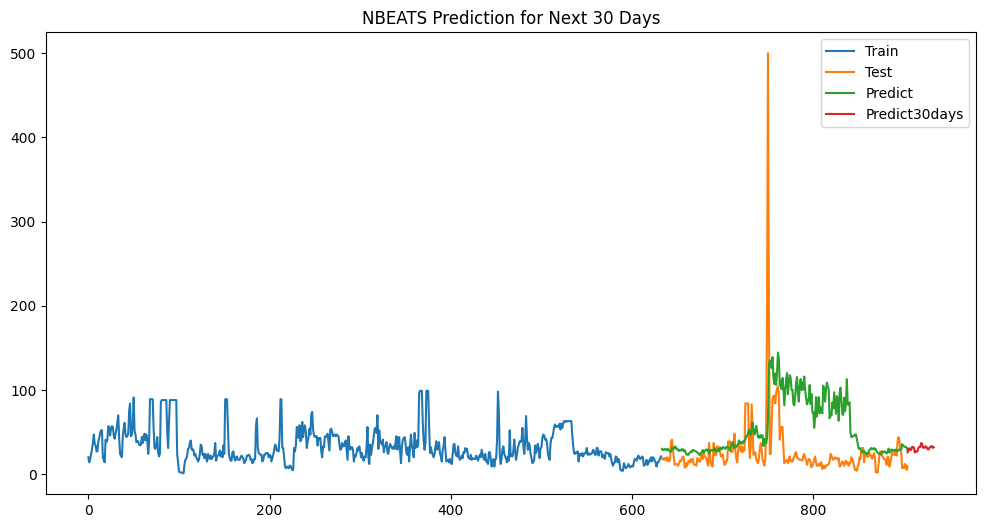

In [149]:
plt.figure(figsize=(12, 6))
train_data_index = pd.RangeIndex(start=0, stop=split_size, step=1)
plt.plot(y_train)
test_data_index = pd.RangeIndex(start=split_size, stop=split_size+test_size, step=1)
plt.plot(test_data_index,y_test)
test_data_index = pd.RangeIndex(start=split_size, stop=split_size+test_size, step=1)
len(test_data_index)
plt.plot(test_data_index,model_preds)
prediect_data_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+29, step=1)
plt.plot(prediect_data_index,future_forecast_array)
plt.title('NBEATS Prediction for Next 30 Days')
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()

**NBEATS(8:2)**


In [150]:
WINDOW_SIZE=90
HORIZON=1
df_aqi

,AQI
date,
2021-02-14,20
2021-02-15,14
2021-02-16,18
2021-02-17,24
2021-02-18,29
...,...
2024-02-26,7
2024-02-27,12
2024-02-28,11


In [151]:
aqi_nbeats = df_aqi.copy()
for i in range(WINDOW_SIZE):
  aqi_nbeats[f"AQI+{i+1}"] = aqi_nbeats["AQI"].shift(periods=i+1)
aqi_nbeats.dropna()

,AQI,AQI+1,AQI+2,AQI+3,AQI+4,AQI+5,AQI+6,AQI+7,AQI+8,AQI+9,...,AQI+81,AQI+82,AQI+83,AQI+84,AQI+85,AQI+86,AQI+87,AQI+88,AQI+89,AQI+90
date,,,,,,,,,,,,,,,,,,,,,
2021-05-30,88,62.0,31.0,51.0,88.0,88.0,88.0,88.0,88.0,88.0,...,27.0,34.0,36.0,47.0,37.0,29.0,24.0,18.0,14.0,20.0
2021-05-31,88,88.0,62.0,31.0,51.0,88.0,88.0,88.0,88.0,88.0,...,27.0,27.0,34.0,36.0,47.0,37.0,29.0,24.0,18.0,14.0
2021-06-01,88,88.0,88.0,62.0,31.0,51.0,88.0,88.0,88.0,88.0,...,39.0,27.0,27.0,34.0,36.0,47.0,37.0,29.0,24.0,18.0
2021-06-02,88,88.0,88.0,88.0,62.0,31.0,51.0,88.0,88.0,88.0,...,43.0,39.0,27.0,27.0,34.0,36.0,47.0,37.0,29.0,24.0
2021-06-03,88,88.0,88.0,88.0,88.0,62.0,31.0,51.0,88.0,88.0,...,49.0,43.0,39.0,27.0,27.0,34.0,36.0,47.0,37.0,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-26,7,8.0,7.0,27.0,31.0,39.0,44.0,39.0,22.0,29.0,...,24.0,15.0,12.0,11.0,11.0,9.0,7.0,10.0,9.0,6.0
2024-02-27,12,7.0,8.0,7.0,27.0,31.0,39.0,44.0,39.0,22.0,...,22.0,24.0,15.0,12.0,11.0,11.0,9.0,7.0,10.0,9.0
2024-02-28,11,12.0,7.0,8.0,7.0,27.0,31.0,39.0,44.0,39.0,...,19.0,22.0,24.0,15.0,12.0,11.0,11.0,9.0,7.0,10.0


In [152]:
# Make features and labels
x = aqi_nbeats.drop("AQI", axis=1)
y = aqi_nbeats["AQI"]
x.fillna(method='ffill', inplace=True)
x.fillna(method='bfill', inplace=True)
y.fillna(method='ffill', inplace=True)
y.fillna(method='bfill', inplace=True)

In [153]:
split_size = int(len(x) * 0.8)
x_train, y_train = x[:split_size], y[:split_size]
x_test, y_test = x[split_size:], y[split_size:]
len(x_train), len(y_train), len(x_test), len(y_test)

(724, 724, 181, 181)

In [154]:
#Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(x_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

#Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 90), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 90), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [155]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 20 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30
INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON
INPUT_SIZE, THETA_SIZE

(90, 91)

In [156]:
# trying tf.keras.layers.add or .subtract
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

subtracted = tf.keras.layers.subtract([tensor_1,tensor_2])
added = tf.keras.layers.add([tensor_1,tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


In [157]:
tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = tf.keras.layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)

residuals = tf.keras.layers.subtract([stack_input, backcast], name=f"subtract_00")

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = tf.keras.layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = tf.keras.layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])

In [158]:
model.evaluate(test_dataset)

1/1 [==============================] - 0s 170ms/step - loss: 71.0108 - mae: 71.0108 - mse: 8522.3691


[71.01082611083984, 71.01082611083984, 8522.369140625]

In [159]:
def make_preds(model, input_data):
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)


def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  return {"mae": mae.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy()}

In [160]:
model_preds = make_preds(model, test_dataset)
model_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_preds)
model_results

1/1 [==============================] - 2s 2s/step


{'mae': 71.010826, 'rmse': 92.31668, 'mape': 471.44476}

In [161]:
INTO_FUTURE = 30
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  #Make an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] # only want preds from the last window (this will get updated)

  #Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time
  for _ in range(into_future):

    # Predict on last window then append it again, again, again (model starts to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())
    # print(future_forecast)

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]

  return future_forecast

In [162]:
future_forecast = make_future_forecast(values=y,
                                       model=model,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 [==============================] - 1s 1s/step
Predicting on: 
 date
2023-09-20    11
2023-09-21    11
2023-09-22    12
2023-09-23    15
2023-09-24    24
              ..
2024-02-26     7
2024-02-27    12
2024-02-28    11
2024-02-29     5
2024-03-01     9
Name: AQI, Length: 90, dtype: int64 -> Prediction: 28.12104034423828

1/1 [==============================] - 2s 2s/step
Predicting on: 
 [11.         12.         15.         24.         22.         19.
 17.         18.         20.         19.         19.         17.
 19.          9.         10.         13.         15.         13.
 10.         14.         16.         12.         14.         10.
 12.         15.         20.         18.         15.         10.
  5.          6.          4.          9.         11.         20.
 18.         31.         27.         31.         14.         22.
 22.         23.         20.         25.         25.         21.
 22.         18.         21.         25.         20.          2.
  2.          2.   

In [163]:
y_train = aqi_arr[:split_size]
y_train = aqi_arr[:split_size]
y_test = aqi_arr[split_size:]
len(y_train), len(y_test)
test_size = len(df)-split_size
future_forecast_array = np.array(future_forecast)

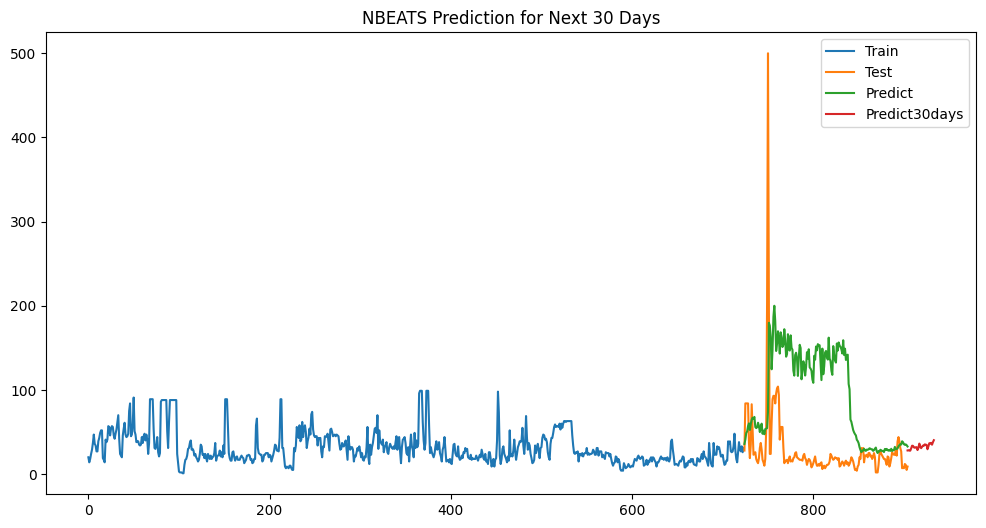

In [164]:
plt.figure(figsize=(12, 6))
train_data_index = pd.RangeIndex(start=0, stop=split_size, step=1)
plt.plot(y_train)
test_data_index = pd.RangeIndex(start=split_size, stop=split_size+test_size, step=1)
plt.plot(test_data_index,y_test)
test_data_index = pd.RangeIndex(start=split_size, stop=split_size+test_size, step=1)
len(test_data_index)
plt.plot(test_data_index,model_preds)
prediect_data_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+29, step=1)
plt.plot(prediect_data_index,future_forecast_array)
plt.title('NBEATS Prediction for Next 30 Days')
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()

**NBEAT(9:1)**

In [165]:
WINDOW_SIZE=90
HORIZON=1
aqi_nbeats = df_aqi.copy()
for i in range(WINDOW_SIZE):
  aqi_nbeats[f"AQI+{i+1}"] = aqi_nbeats["AQI"].shift(periods=i+1)
aqi_nbeats.dropna()

,AQI,AQI+1,AQI+2,AQI+3,AQI+4,AQI+5,AQI+6,AQI+7,AQI+8,AQI+9,...,AQI+81,AQI+82,AQI+83,AQI+84,AQI+85,AQI+86,AQI+87,AQI+88,AQI+89,AQI+90
date,,,,,,,,,,,,,,,,,,,,,
2021-05-30,88,62.0,31.0,51.0,88.0,88.0,88.0,88.0,88.0,88.0,...,27.0,34.0,36.0,47.0,37.0,29.0,24.0,18.0,14.0,20.0
2021-05-31,88,88.0,62.0,31.0,51.0,88.0,88.0,88.0,88.0,88.0,...,27.0,27.0,34.0,36.0,47.0,37.0,29.0,24.0,18.0,14.0
2021-06-01,88,88.0,88.0,62.0,31.0,51.0,88.0,88.0,88.0,88.0,...,39.0,27.0,27.0,34.0,36.0,47.0,37.0,29.0,24.0,18.0
2021-06-02,88,88.0,88.0,88.0,62.0,31.0,51.0,88.0,88.0,88.0,...,43.0,39.0,27.0,27.0,34.0,36.0,47.0,37.0,29.0,24.0
2021-06-03,88,88.0,88.0,88.0,88.0,62.0,31.0,51.0,88.0,88.0,...,49.0,43.0,39.0,27.0,27.0,34.0,36.0,47.0,37.0,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-26,7,8.0,7.0,27.0,31.0,39.0,44.0,39.0,22.0,29.0,...,24.0,15.0,12.0,11.0,11.0,9.0,7.0,10.0,9.0,6.0
2024-02-27,12,7.0,8.0,7.0,27.0,31.0,39.0,44.0,39.0,22.0,...,22.0,24.0,15.0,12.0,11.0,11.0,9.0,7.0,10.0,9.0
2024-02-28,11,12.0,7.0,8.0,7.0,27.0,31.0,39.0,44.0,39.0,...,19.0,22.0,24.0,15.0,12.0,11.0,11.0,9.0,7.0,10.0


In [166]:
# Make features and labels
x = aqi_nbeats.drop("AQI", axis=1)
y = aqi_nbeats["AQI"]
x.fillna(method='ffill', inplace=True)
x.fillna(method='bfill', inplace=True)
y.fillna(method='ffill', inplace=True)
y.fillna(method='bfill', inplace=True)

In [167]:
split_size = int(len(x) * 0.9)
x_train, y_train = x[:split_size], y[:split_size]
x_test, y_test = x[split_size:], y[split_size:]
len(x_train), len(y_train), len(x_test), len(y_test)

(814, 814, 91, 91)

In [168]:
#Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(x_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

#Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 90), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 90), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [169]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 20 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30
INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON
INPUT_SIZE, THETA_SIZE

(90, 91)

In [170]:
# trying tf.keras.layers.add or .subtract
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

subtracted = tf.keras.layers.subtract([tensor_1,tensor_2])
added = tf.keras.layers.add([tensor_1,tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


In [171]:
tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = tf.keras.layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)

residuals = tf.keras.layers.subtract([stack_input, backcast], name=f"subtract_00")

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = tf.keras.layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = tf.keras.layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])

In [172]:
model.evaluate(test_dataset)

1/1 [==============================] - 0s 199ms/step - loss: 11.2981 - mae: 11.2981 - mse: 257.8297


[11.298072814941406, 11.298072814941406, 257.8297424316406]

In [173]:
model.evaluate(test_dataset)
def make_preds(model, input_data):
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)


def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  return {"mae": mae.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy()}

1/1 [==============================] - 0s 181ms/step - loss: 11.2981 - mae: 11.2981 - mse: 257.8297


In [174]:
model_preds = make_preds(model, test_dataset)
model_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_preds)
model_results

1/1 [==============================] - 2s 2s/step


{'mae': 11.298073, 'rmse': 16.057077, 'mape': 90.31787}

In [175]:
INTO_FUTURE = 30
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  #Make an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] # only want preds from the last window (this will get updated)

  #Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time
  for _ in range(into_future):

    # Predict on last window then append it again, again, again (model starts to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())
    # print(future_forecast)

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]

  return future_forecast

In [176]:
future_forecast = make_future_forecast(values=y,
                                       model=model,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 [==============================] - 2s 2s/step
Predicting on: 
 date
2023-09-20    11
2023-09-21    11
2023-09-22    12
2023-09-23    15
2023-09-24    24
              ..
2024-02-26     7
2024-02-27    12
2024-02-28    11
2024-02-29     5
2024-03-01     9
Name: AQI, Length: 90, dtype: int64 -> Prediction: 10.34312629699707

1/1 [==============================] - 2s 2s/step
Predicting on: 
 [11.        12.        15.        24.        22.        19.
 17.        18.        20.        19.        19.        17.
 19.         9.        10.        13.        15.        13.
 10.        14.        16.        12.        14.        10.
 12.        15.        20.        18.        15.        10.
  5.         6.         4.         9.        11.        20.
 18.        31.        27.        31.        14.        22.
 22.        23.        20.        25.        25.        21.
 22.        18.        21.        25.        20.         2.
  2.         2.        11.        24.        27.        24.
 22.

In [177]:
y_train = aqi_arr[:split_size]
y_train = aqi_arr[:split_size]
y_test = aqi_arr[split_size:]
len(y_train), len(y_test)
test_size = len(df)-split_size
future_forecast_array = np.array(future_forecast)

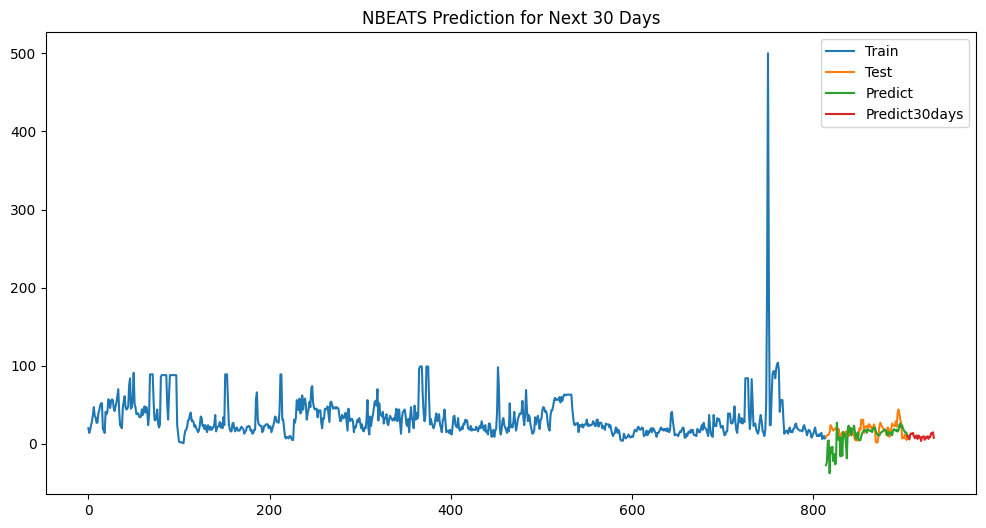

In [178]:
plt.figure(figsize=(12, 6))
train_data_index = pd.RangeIndex(start=0, stop=split_size, step=1)
plt.plot(y_train)
test_data_index = pd.RangeIndex(start=split_size, stop=split_size+test_size, step=1)
plt.plot(test_data_index,y_test)
test_data_index = pd.RangeIndex(start=split_size, stop=split_size+test_size, step=1)
len(test_data_index)
plt.plot(test_data_index,model_preds)
prediect_data_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+29, step=1)
plt.plot(prediect_data_index,future_forecast_array)
plt.title('NBEATS Prediction for Next 30 Days')
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()